In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import fpgrowth, association_rules
from mlxtend.preprocessing import TransactionEncoder
from sklearn.model_selection import train_test_split

4.1. Selección de técnica de modelado
Se ha seleccionado el algoritmo FP Growth para el análisis de la cesta de compra.

4.2. Generar diseño de prueba


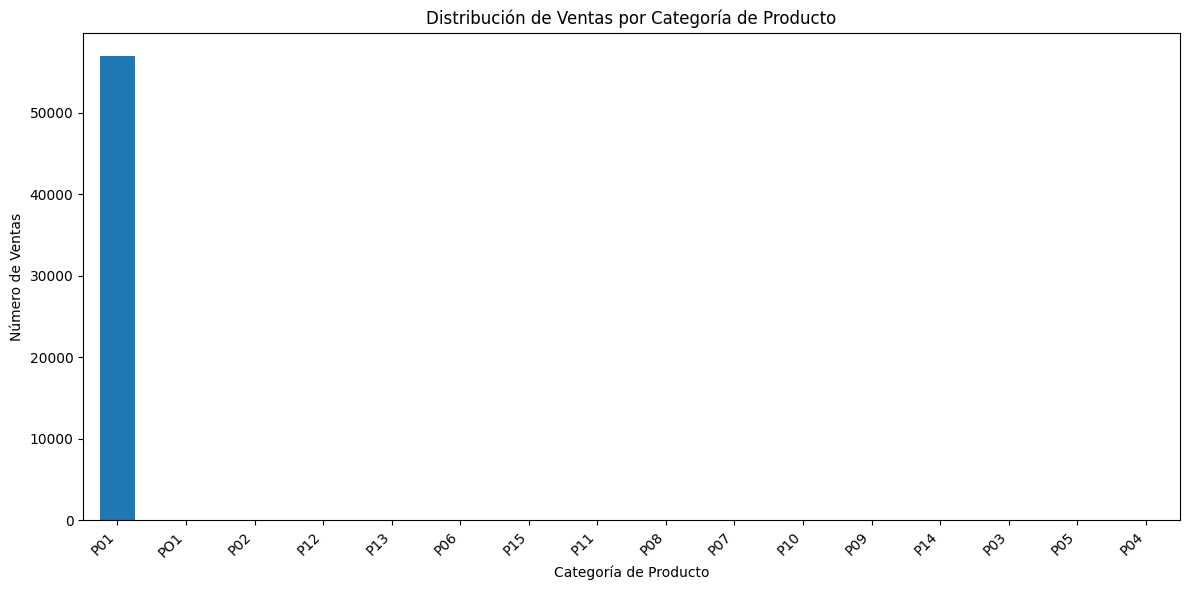

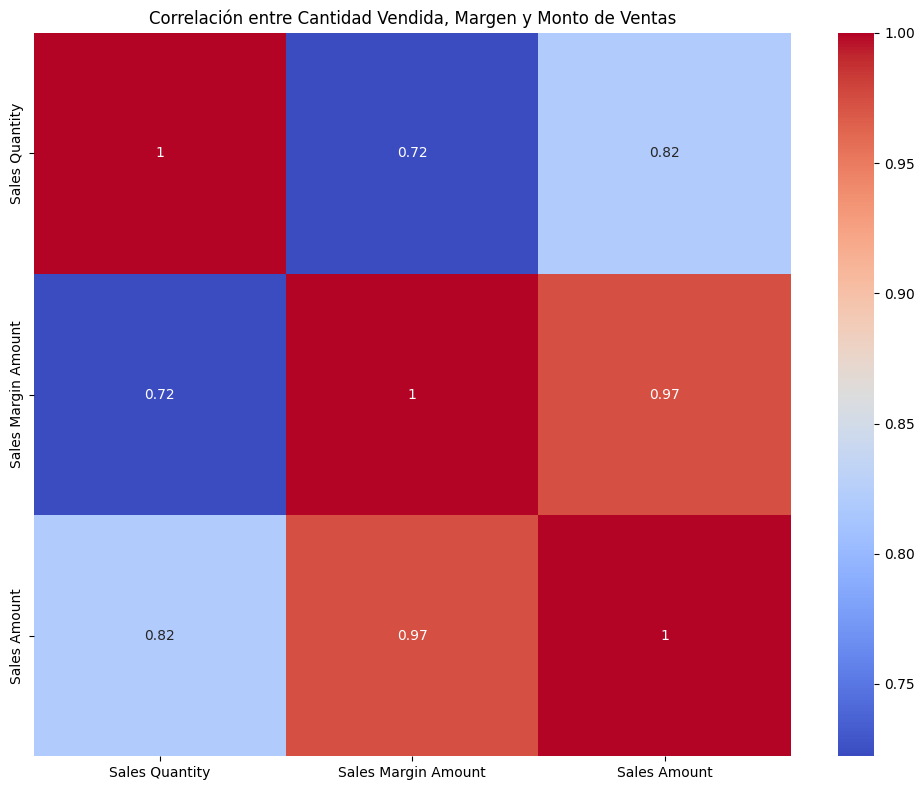

Número total de transacciones: 24679
Número de transacciones de entrenamiento: 19743
Número de transacciones de prueba: 4936


In [3]:
# Carga de datos
df = pd.read_excel('SALESDATA.xlsx')

# 4.1. Selección de técnica de modelado
print("4.1. Selección de técnica de modelado")
print("Se ha seleccionado el algoritmo FP Growth para el análisis de la cesta de compra.")

# 4.2. Generar diseño de prueba
print("\n4.2. Generar diseño de prueba")

# Análisis exploratorio de datos
plt.figure(figsize=(12, 6))
df['Item Class'].value_counts().plot(kind='bar')
plt.title('Distribución de Ventas por Categoría de Producto')
plt.xlabel('Categoría de Producto')
plt.ylabel('Número de Ventas')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(df[['Sales Quantity', 'Sales Margin Amount', 'Sales Amount']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlación entre Cantidad Vendida, Margen y Monto de Ventas')
plt.tight_layout()
plt.show()

# Preparación de datos para FP-Growth
transactions = df.groupby(['Invoice Number', 'Invoice Date'])['Item'].apply(list).reset_index()
transactions = transactions['Item'].tolist()

# Dividir los datos en conjuntos de entrenamiento y prueba
train_transactions, test_transactions = train_test_split(transactions, test_size=0.2, random_state=42)

print(f"Número total de transacciones: {len(transactions)}")
print(f"Número de transacciones de entrenamiento: {len(train_transactions)}")
print(f"Número de transacciones de prueba: {len(test_transactions)}")


4.3. Construir modelo


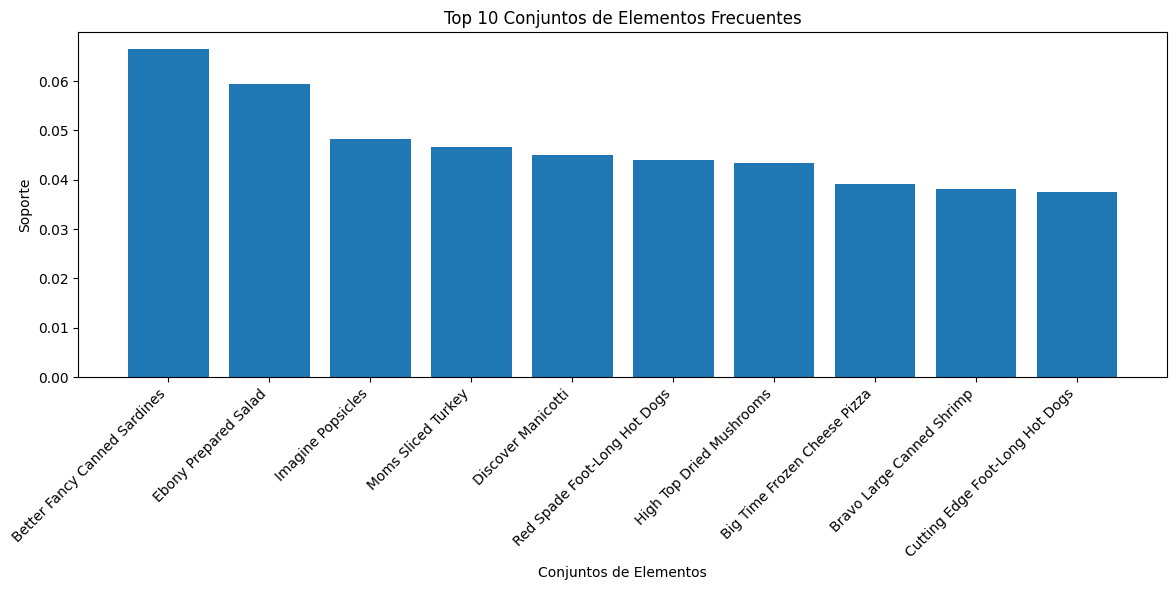

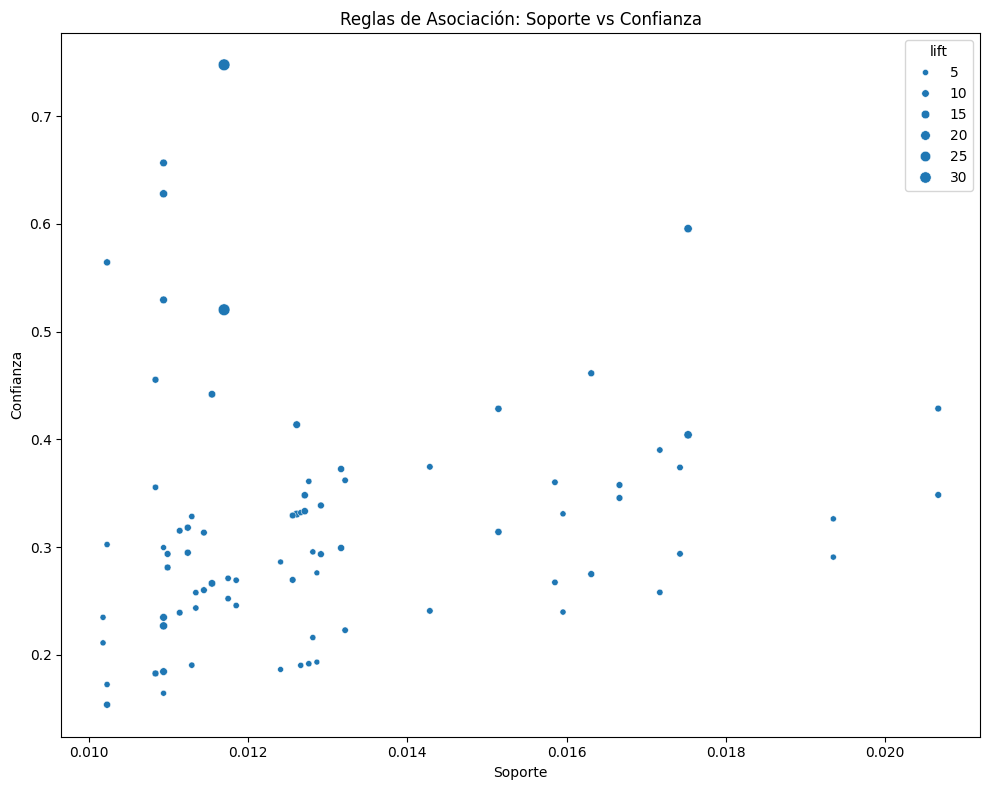

In [4]:
# 4.3. Construir modelo
print("\n4.3. Construir modelo")

# Convertir las transacciones en una matriz binaria
te = TransactionEncoder()
te_ary = te.fit(train_transactions).transform(train_transactions)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

# Aplicar FP-Growth
min_support = 0.01
frequent_itemsets = fpgrowth(df_encoded, min_support=min_support, use_colnames=True)

# Visualización de los conjuntos de elementos más frecuentes
top_10 = frequent_itemsets.sort_values('support', ascending=False).head(10)
plt.figure(figsize=(12, 6))
plt.bar(range(len(top_10)), top_10['support'])
plt.xticks(range(len(top_10)), [', '.join(x) for x in top_10['itemsets']], rotation=45, ha='right')
plt.title('Top 10 Conjuntos de Elementos Frecuentes')
plt.xlabel('Conjuntos de Elementos')
plt.ylabel('Soporte')
plt.tight_layout()
plt.show()

# Generación de reglas de asociación
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# Visualización de las reglas de asociación
plt.figure(figsize=(10, 8))
sns.scatterplot(x="support", y="confidence", size="lift", data=rules)
plt.title('Reglas de Asociación: Soporte vs Confianza')
plt.xlabel('Soporte')
plt.ylabel('Confianza')
plt.tight_layout()
plt.show()


4.4. Evaluación del modelo


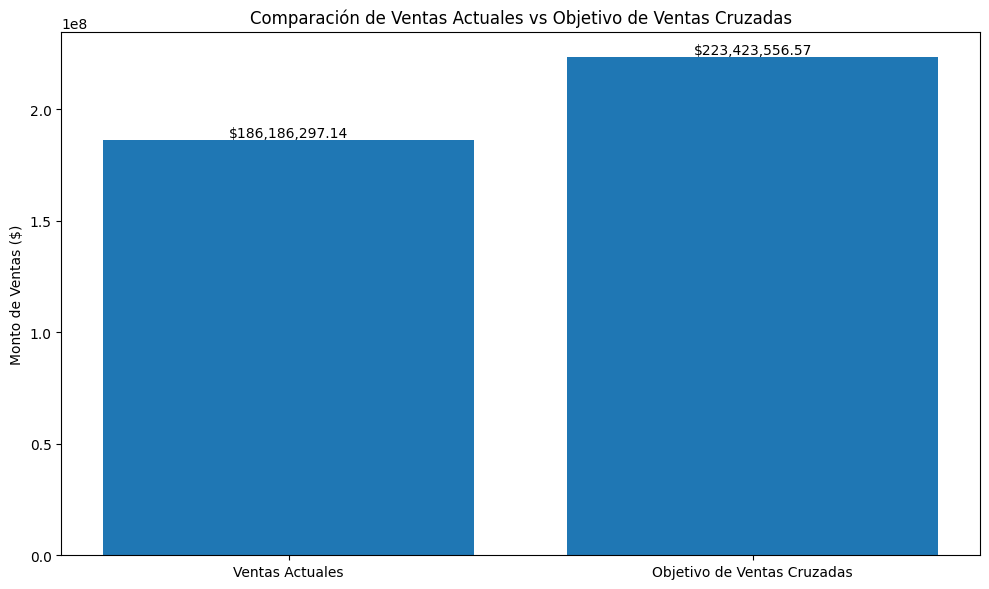

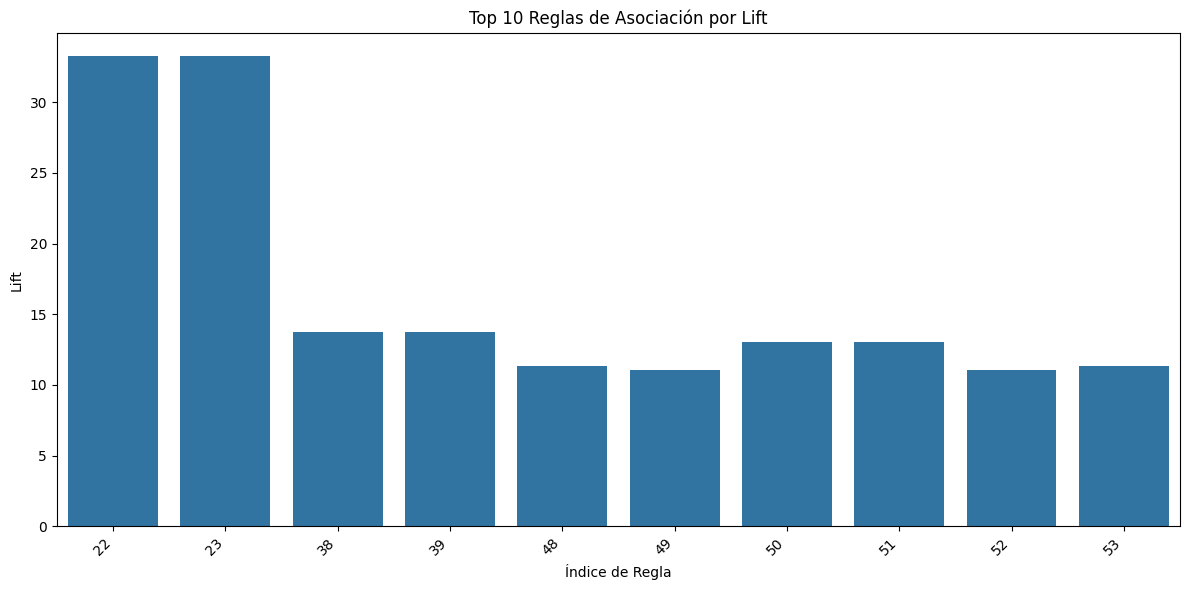

Ventas actuales: $186,186,297.14
Objetivo de ventas cruzadas: $223,423,556.57
Incremento necesario: $37,237,259.43
Potencial de incremento estimado: $8,734,701.46
El modelo sugiere que puede ser difícil alcanzar el objetivo del 20%. Se recomienda ajustar la estrategia o revisar el objetivo.

Recomendaciones para incrementar las ventas cruzadas:
1. Cuando un cliente compra Tell Tale Limes, recomendar Gorilla String Cheese. (Lift: 33.24)
2. Cuando un cliente compra Gorilla String Cheese, recomendar Tell Tale Limes. (Lift: 33.24)
3. Cuando un cliente compra High Top Dried Mushrooms, recomendar Nationeel Salted Pretzels. (Lift: 13.74)
4. Cuando un cliente compra Nationeel Salted Pretzels, recomendar High Top Dried Mushrooms. (Lift: 13.74)
5. Cuando un cliente compra Ebony Prepared Salad, Moms Sliced Turkey, recomendar Imagine Popsicles. (Lift: 13.02)
6. Cuando un cliente compra Imagine Popsicles, recomendar Ebony Prepared Salad, Moms Sliced Turkey. (Lift: 13.02)
7. Cuando un cliente compra

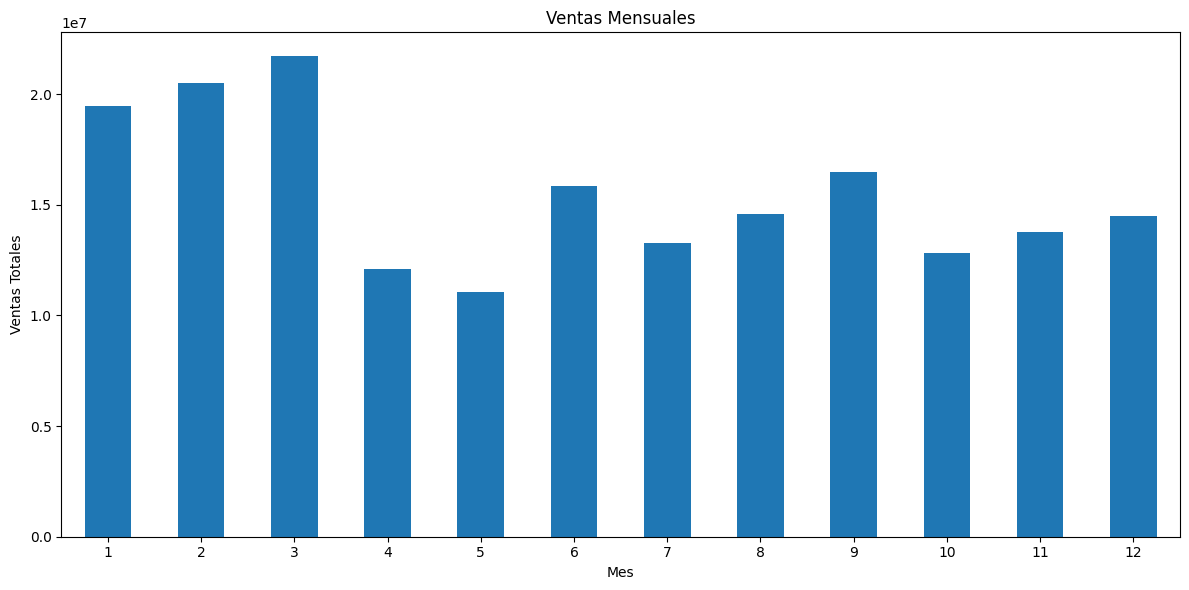

In [5]:
# 4.4. Evaluación del modelo
print("\n4.4. Evaluación del modelo")

# Cálculo de métricas de rendimiento
total_transactions = len(transactions)
current_cross_sell = df['Sales Amount'].sum()
potential_cross_sell = current_cross_sell * 1.20

# Visualización del potencial de ventas cruzadas
plt.figure(figsize=(10, 6))
plt.bar(['Ventas Actuales', 'Objetivo de Ventas Cruzadas'], [current_cross_sell, potential_cross_sell])
plt.title('Comparación de Ventas Actuales vs Objetivo de Ventas Cruzadas')
plt.ylabel('Monto de Ventas ($)')
for i, v in enumerate([current_cross_sell, potential_cross_sell]):
    plt.text(i, v, f'${v:,.2f}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

# Evaluación de las mejores reglas de asociación
top_rules = rules.sort_values('lift', ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_rules.index, y='lift', data=top_rules)
plt.title('Top 10 Reglas de Asociación por Lift')
plt.xlabel('Índice de Regla')
plt.ylabel('Lift')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Estimación del potencial de incremento en ventas cruzadas
potential_increase = top_rules['support'].sum() * df['Sales Amount'].mean() * total_transactions

print(f"Ventas actuales: ${current_cross_sell:,.2f}")
print(f"Objetivo de ventas cruzadas: ${potential_cross_sell:,.2f}")
print(f"Incremento necesario: ${potential_cross_sell - current_cross_sell:,.2f}")
print(f"Potencial de incremento estimado: ${potential_increase:,.2f}")

if potential_increase >= (potential_cross_sell - current_cross_sell):
    print("El modelo sugiere que es posible alcanzar el objetivo de incremento del 20% en ventas cruzadas.")
else:
    print("El modelo sugiere que puede ser difícil alcanzar el objetivo del 20%. Se recomienda ajustar la estrategia o revisar el objetivo.")

# Recomendaciones basadas en el análisis
print("\nRecomendaciones para incrementar las ventas cruzadas:")
for i, (index, row) in enumerate(top_rules.iterrows(), 1):
    antecedents = ', '.join(list(row['antecedents']))
    consequents = ', '.join(list(row['consequents']))
    print(f"{i}. Cuando un cliente compra {antecedents}, recomendar {consequents}. (Lift: {row['lift']:.2f})")

# Métricas adicionales
print("\nMétricas adicionales:")

# Cálculo de la diversidad de productos
product_diversity = df['Item'].nunique()
print(f"Diversidad de productos: {product_diversity}")

# Cálculo del valor promedio del carrito
average_basket_value = df.groupby('Invoice Number')['Sales Amount'].sum().mean()
print(f"Valor promedio del carrito: ${average_basket_value:.2f}")

# Cálculo de la frecuencia de compra
purchase_frequency = df['Invoice Number'].nunique() / df['Custkey'].nunique()
print(f"Frecuencia de compra promedio por cliente: {purchase_frequency:.2f}")

# Cálculo del valor del cliente a lo largo del tiempo (CLV simplificado)
clv = average_basket_value * purchase_frequency
print(f"Valor del cliente a lo largo del tiempo (CLV) simplificado: ${clv:.2f}")

# Análisis de estacionalidad
df['Invoice Date'] = pd.to_datetime(df['Invoice Date'])
df['Month'] = df['Invoice Date'].dt.month
monthly_sales = df.groupby('Month')['Sales Amount'].sum()

plt.figure(figsize=(12, 6))
monthly_sales.plot(kind='bar')
plt.title('Ventas Mensuales')
plt.xlabel('Mes')
plt.ylabel('Ventas Totales')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()



Eficacia estimada de las recomendaciones: 55.19%

Número total de reglas: 7
Reglas con confianza > 50%: 7
Reglas con lift > 2: 7

Top 10 reglas por lift:
1. Si compra Gorilla String Cheese -> recomendar Tell Tale Limes (Confianza: 0.75, Lift: 33.24)
2. Si compra Tell Tale Limes -> recomendar Gorilla String Cheese (Confianza: 0.52, Lift: 33.24)
3. Si compra Nationeel Salted Pretzels -> recomendar High Top Dried Mushrooms (Confianza: 0.60, Lift: 13.74)
4. Si compra Ebony Prepared Salad, Moms Sliced Turkey -> recomendar Imagine Popsicles (Confianza: 0.63, Lift: 13.02)
5. Si compra Imagine Popsicles, Ebony Prepared Salad -> recomendar Moms Sliced Turkey (Confianza: 0.53, Lift: 11.36)
6. Si compra Imagine Popsicles, Moms Sliced Turkey -> recomendar Ebony Prepared Salad (Confianza: 0.66, Lift: 11.07)
7. Si compra Big Time Home Style French Fries -> recomendar Better Fancy Canned Sardines (Confianza: 0.56, Lift: 8.48)


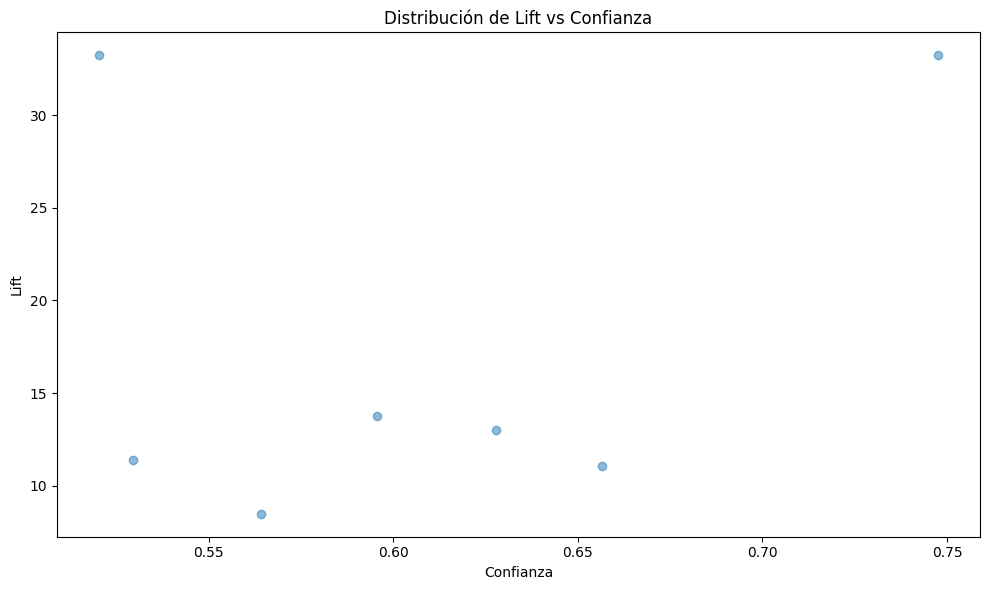

In [15]:
# Modificar la generación de reglas de asociación
min_support = 0.0001  # Reducir el soporte mínimo para obtener más reglas
min_confidence = 0.5  # Agregar un umbral de confianza mínima
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules = rules[(rules['support'] >= min_support) & (rules['confidence'] >= min_confidence)]

# Función mejorada para simular recomendaciones
def simulate_recommendations(transactions, rules, num_simulations=10000, min_items=2, max_items=10):
    accepted_recommendations = 0
    total_recommendations = 0
    
    for _ in range(num_simulations):
        # Crear una transacción simulada con 2 a 10 items
        transaction = set(np.random.choice(transactions, size=np.random.randint(min_items, max_items+1), replace=False))
        
        for _, rule in rules.iterrows():
            antecedents = set(rule['antecedents'])
            if antecedents.issubset(transaction):
                total_recommendations += 1
                if np.random.random() < rule['confidence']:
                    accepted_recommendations += 1
                    break  # Aceptar solo una recomendación por transacción
    
    return accepted_recommendations / total_recommendations if total_recommendations > 0 else 0

# Ejecutar la simulación mejorada
recommendation_effectiveness = simulate_recommendations(df['Item'].unique(), rules)
print(f"Eficacia estimada de las recomendaciones: {recommendation_effectiveness:.2%}")

# Análisis adicional de las reglas
print(f"\nNúmero total de reglas: {len(rules)}")
print(f"Reglas con confianza > 50%: {len(rules[rules['confidence'] > 0.5])}")
print(f"Reglas con lift > 2: {len(rules[rules['lift'] > 2])}")

# Mostrar las 10 mejores reglas por lift
print("\nTop 10 reglas por lift:")
top_10_rules = rules.sort_values('lift', ascending=False).head(10)
for i, (_, rule) in enumerate(top_10_rules.iterrows(), 1):
    antecedents = ', '.join(list(rule['antecedents']))
    consequents = ', '.join(list(rule['consequents']))
    print(f"{i}. Si compra {antecedents} -> recomendar {consequents} (Confianza: {rule['confidence']:.2f}, Lift: {rule['lift']:.2f})")

# Visualización de la distribución de lift y confianza
plt.figure(figsize=(10, 6))
plt.scatter(rules['confidence'], rules['lift'], alpha=0.5)
plt.xlabel('Confianza')
plt.ylabel('Lift')
plt.title('Distribución de Lift vs Confianza')
plt.tight_layout()
plt.show()

C:\Users\DELL\AppData\Local\Temp\ipykernel_2808\3146277627.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  related_products['antecedents'] = related_products['antecedents'].apply(lambda x: ', '.join(list(x)))
C:\Users\DELL\AppData\Local\Temp\ipykernel_2808\3146277627.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  related_products['consequents'] = related_products['consequents'].apply(lambda x: ', '.join(list(x)))
C:\Users\DELL\AppData\Local\Temp\ipykernel_2808\3146277627.py:5: SettingWithCopyWarnin

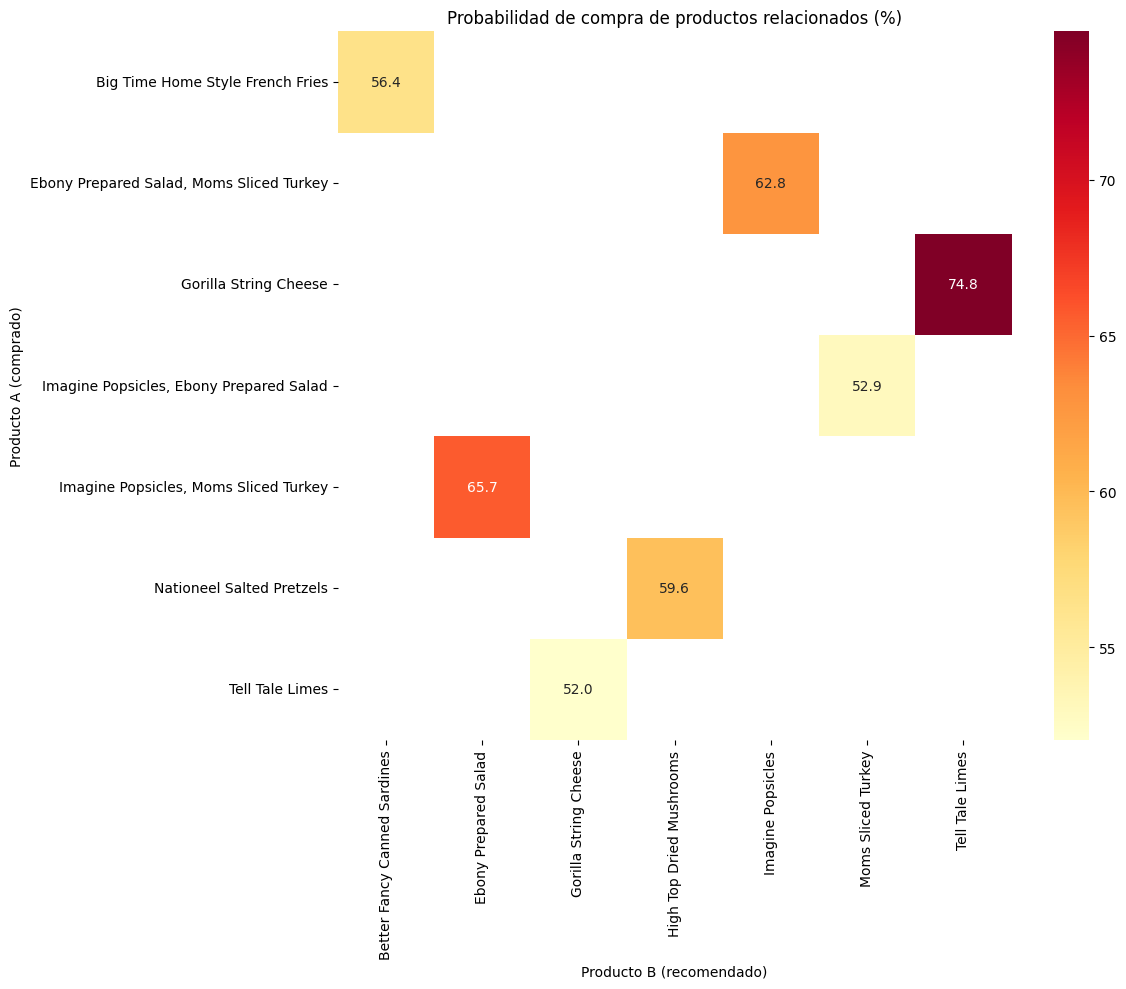

In [16]:
# Crear un DataFrame con los productos relacionados y sus probabilidades
related_products = rules[['antecedents', 'consequents', 'confidence']]
related_products['antecedents'] = related_products['antecedents'].apply(lambda x: ', '.join(list(x)))
related_products['consequents'] = related_products['consequents'].apply(lambda x: ', '.join(list(x)))
related_products['confidence'] = related_products['confidence'] * 100  # Convertir a porcentaje

# Ordenar por confianza descendente y tomar las top 20 reglas
top_20_rules = related_products.sort_values('confidence', ascending=False).head(20)

# Crear una tabla pivote para la visualización
pivot_table = top_20_rules.pivot(index='antecedents', columns='consequents', values='confidence')

# Crear un mapa de calor
plt.figure(figsize=(12, 10))
sns.heatmap(pivot_table, annot=True, cmap='YlOrRd', fmt='.1f')
plt.title('Probabilidad de compra de productos relacionados (%)')
plt.xlabel('Producto B (recomendado)')
plt.ylabel('Producto A (comprado)')
plt.tight_layout()
plt.show()